In [35]:
import torch
from denoising_diffusion_pytorch.classifier_free_guidance_1d import Unet1D, GaussianDiffusion1D
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import norm
from scipy.stats import gaussian_kde

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mixture of Gaussians Toy Example

We generate a mixture of 6 gaussians divided into two classes: class 0 is the mixture of the first three gaussians, class 1 is the mixture of the last three gaussians. Training checkpoints will be saved into model_checkpoints. Please use environment parallel_toy (it is a pip install -e . of denoising-diffusion-pytorch)

### Hyperparameters

First we have our training configuration

In [36]:
# ----- Data Configuration -----
num_samples = 3000
num_modes_per_class = 3
num_classes = 2

means_class0 = np.array([0.1, 0.25, 0.4])
means_class1 = np.array([0.55, 0.7, 0.85])

sigma = 0.025


Two booleans: training boolean controls whether or not you want to train. loading boolean controls whether or not you want to load an existing checkpoint. If you want to
1. Just train: `training_bool = True` and `loading_bool = False`. This will ignore any of the loading hyperparameters
2. Just sample: `training_bool = False` and `loading_bool = True`. This will ignore any of the training hyperparameters
3. Continue training: `training_bool = True` and `loading_bool = True`

In [37]:
training_bool = True
train_num_steps = 50000
training_batch_size = 128

loading_bool = False
loading_num_steps= 1000
loading_file = f"unet_gauss_cfg_{loading_num_steps}"

We have some code for plotting our histograms. Tick marks are added to where each Gaussian mean is (so should be 6 means)

In [38]:
def plot(sampled_seq,  title = None, bins=100, bw=0.05):
    if isinstance(sampled_seq, np.ndarray):
        X = sampled_seq
    else:
        X = (
            sampled_seq
            .squeeze(-2)
            .detach()
            .cpu()
            .numpy()
        )

    X = X.ravel()

    # Histogram (probability per bin)
    counts, bin_edges = np.histogram(X, bins=bins)
    probs = counts / counts.sum()
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    width = bin_edges[1] - bin_edges[0]

    plt.bar(bin_centers, probs, width=width, alpha=0.4, label="Histogram")



    # Convert density to "probability per bin" scale
    # plt.plot(x_grid, density * width, lw=2, label="KDE")

    plt.scatter(means_class0, np.zeros_like(means_class0), marker = "^")
    plt.scatter(means_class1, np.zeros_like(means_class0), marker = "^")

    plt.xlabel("x")
    plt.ylabel("Probability per bin")
    plt.legend()
    if title:
        plt.title(title)
    plt.show()

### Generating Samples

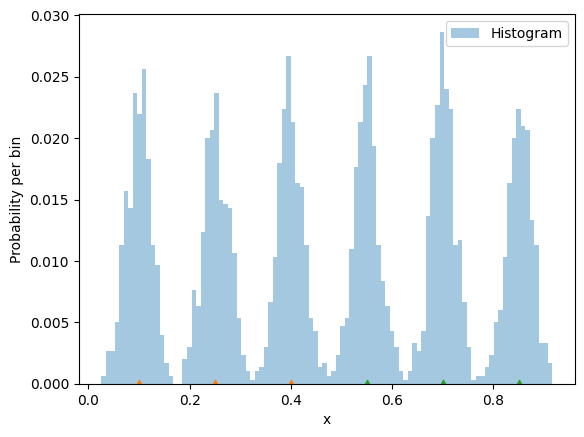

0.47548200842519933
0.06586192272624415


In [39]:
# ----- Creating training dataset -----
# Sample class labels uniformly
labels = np.random.randint(0, 2, size=num_samples)

# Sample mode indices within each class
mode_idx = np.random.randint(0, num_modes_per_class, size=num_samples)

# Allocate array
X = np.zeros(num_samples)

# Class 0 samples
mask0 = labels == 0
X[mask0] = (
    means_class0[mode_idx[mask0]] +
    sigma * np.random.randn(mask0.sum())
)

# Class 1 samples
mask1 = labels == 1
X[mask1] = (
    means_class1[mode_idx[mask1]] +
    sigma * np.random.randn(mask1.sum())
)

plot(X)

print(X.mean().item())
print(X.var().item())

training_seq = torch.tensor(X).unsqueeze(-1).unsqueeze(-1).float()
labels = torch.tensor(labels)

channels = 1
seq_length = 1

## Training and Sampling Code

In [ ]:
model = Unet1D(
    dim=64,
    dim_mults=(1,),
    channels=channels,
    num_classes=num_classes
)

diffusion = GaussianDiffusion1D(
    model,
    seq_length=seq_length,
    timesteps=1000,
    objective='pred_v'
).cuda()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

if loading_bool:

    state_dict = torch.load(f"model_checkpoints/{loading_file}.pt")
    model.load_state_dict(state_dict)
    print(f"Successfully loaded training from {loading_file}")
    
if training_bool:

    if loading_bool:
        remaining_num_steps = train_num_steps - loading_num_steps
    else:
        remaining_num_steps = train_num_steps


    for i in range(remaining_num_steps):
            
        optimizer.zero_grad()  # Clear gradients from previous step

        indices = torch.randint(0, num_samples, (training_batch_size,1))

        training_batch = training_seq[indices].squeeze(-1).cuda()
        labels_batch = labels[indices].squeeze(-1).int().cuda()
        
        loss = diffusion(training_batch, classes = labels_batch)
        loss.backward()
        optimizer.step()

        if i % 100 ==0:
            print(f"loss value at step {i} of {loss}")
    
    torch.save(model.state_dict(), f"model_checkpoints/unet_gauss_cfg_{train_num_steps}.pt")
    print(f"Successfully finished training for {remaining_num_steps} steps")

loss value at step 0 of 0.33281245827674866


loss value at step 100 of 0.2711977958679199
loss value at step 200 of 0.2651631832122803
loss value at step 300 of 0.20268170535564423
loss value at step 400 of 0.29511839151382446
loss value at step 500 of 0.19663318991661072
loss value at step 600 of 0.21592944860458374
loss value at step 700 of 0.23571071028709412
loss value at step 800 of 0.3159808814525604
loss value at step 900 of 0.4042438864707947
loss value at step 1000 of 0.31096652150154114
loss value at step 1100 of 0.42616331577301025
loss value at step 1200 of 0.21587955951690674
loss value at step 1300 of 0.20224401354789734
loss value at step 1400 of 0.270072877407074
loss value at step 1500 of 0.22508521378040314
loss value at step 1600 of 0.1556834578514099
loss value at step 1700 of 0.36079442501068115
loss value at step 1800 of 0.28924331068992615
loss value at step 1900 of 0.2586095333099365
loss value at step 2000 of 0.24643436074256897
loss value at step 2100 of 0.24363887310028076
loss value at step 2200 of 0.1

## Generating Samples with Standard CFG

Some sampling parameters to note

1. $k$ is temporal score rescaling 
2. $k_{cns}$ is constant noise scaling
3. `cond_scale` is condition scaling, anything greater than 1 strengthens the classifier free guidance. reportedly 3-8 is good empirically
4. `class_sampling = 0` will produce samples on left, `class_sampling = 1` on the right

In [ ]:
cond_scale = 1.0
batch_size = 3000
class_sampling = 0
k = 1.0
k_cns = 1.0

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

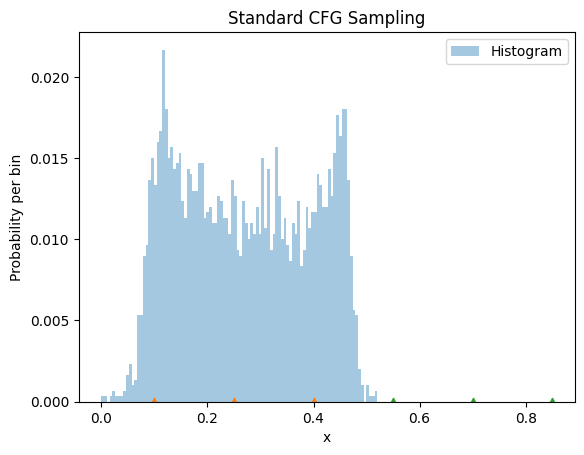

In [ ]:
data_classes = torch.zeros(batch_size, device=device, dtype=torch.int) 
sampled_seq = diffusion.sample(
    k = k,
    k_cns = k_cns,
    classes = data_classes,
    cond_scale = 6.                # condition scaling, anything greater than 1 strengthens the classifier free guidance. reportedly 3-8 is good empirically
    )

plot(sampled_seq, "Standard CFG Sampling")

## Generating Samples with CNS

In [ ]:
k = 1
k_cns = 5

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

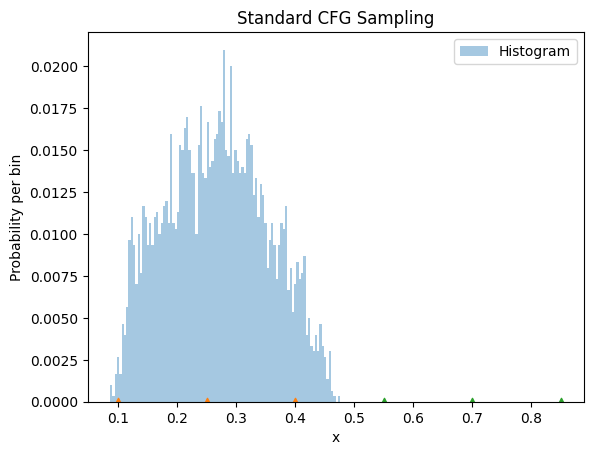

In [ ]:
data_classes = torch.zeros(batch_size, device=device, dtype=torch.int) 
sampled_seq = diffusion.sample(
    k = k,
    k_cns = k_cns,
    classes = data_classes,
    cond_scale = 6.                # condition scaling, anything greater than 1 strengthens the classifier free guidance. reportedly 3-8 is good empirically
    )

plot(sampled_seq, "Standard CFG Sampling")

## Generating Samples with TSR

In [ ]:
k = 2
k_cns =1

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

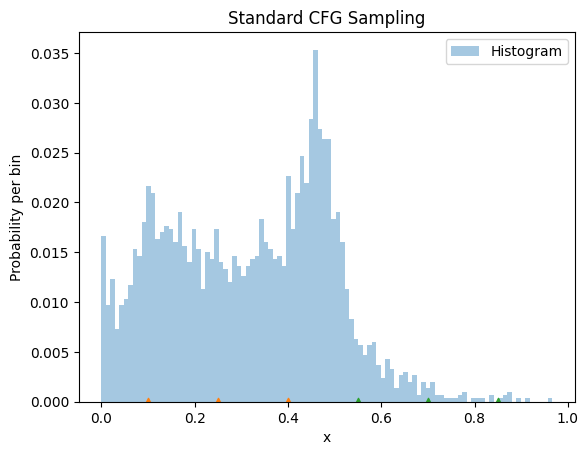

In [ ]:
data_classes = torch.zeros(batch_size, device=device, dtype=torch.int) 
sampled_seq = diffusion.sample(
    k = k,
    k_cns = k_cns,
    classes = data_classes,
    cond_scale = 6.                # condition scaling, anything greater than 1 strengthens the classifier free guidance. reportedly 3-8 is good empirically
    )

plot(sampled_seq, "Standard CFG Sampling")